In this notebook, I will be impementig transfer learnig using 10 breeds in order to improve the results obtained in the previous notebook (CNN from scratch).

I will be testing:

* 3 different models (Xception, VGG16 and Inception V3)
* Flatten vs Global Average Pooling
* Different optimizers (Adam, SGD and RMSProp)
* Fine tuning with low learnig rate (a=10-5)

The most performing model will be used for scaling from 10 to 120 breeds. The results of the generalization will be discussed in another notebook.

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from tensorflow import keras
import cv2
from glob import glob

from keras.models import model_from_json

# Xception 10 breeds

## Data preprocessing

In [ ]:
# rescale images and use data augmentation on the training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# reshape images to 299*299 (recommended size for Xception)
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
# list of 10 breeds
list(training_set.class_indices.keys())

['American_Staffordshire_terrier',
 'Chihuahua',
 'Ibizan_hound',
 'Saluki',
 'Scottish_deerhound',
 'basset',
 'papillon',
 'redbone',
 'toy_terrier',
 'whippet']

## model

Xception model with pre-trained weights

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83689472/83683744 [==============================] - 1s 0us/step


Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(32, activation='relu')
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 10)                2048010   
Total params: 22,909,490
Trainable params: 2,048,010
Non-trainable params: 20,861,480
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 1094s 24s/step - loss: 6.4030 - accuracy: 0.6682 - val_loss: 0.9324 - val_accuracy: 0.9435
Epoch 2/100
46/46 [==============================] - 36s 786ms/step - loss: 1.6564 - accuracy: 0.8971 - val_loss: 1.1268 - val_accuracy: 0.9322
Epoch 3/100
46/46 [==============================] - 36s 789ms/step - loss: 1.6946 - accuracy: 0.9144 - val_loss: 1.6613 - val_accuracy: 0.9435
Epoch 4/100
46/46 [==============================] - 36s 785ms/step - loss: 1.7511 - accuracy: 0.9159 - val_loss: 1.0844 - val_accuracy: 0.9548
Epoch 5/100
46/46 [==============================] - 36s 781ms/step - loss: 1.2028 - accuracy: 0.9420 - val_loss: 1.1260 - val_accuracy: 0.9548
Epoch 6/100
46/46 [==============================] - 36s 775ms/step - loss: 1.2453 - accuracy: 0.9386 - val_loss: 1.7954 - val_accuracy: 0.9322


Accuracy vs Epochs

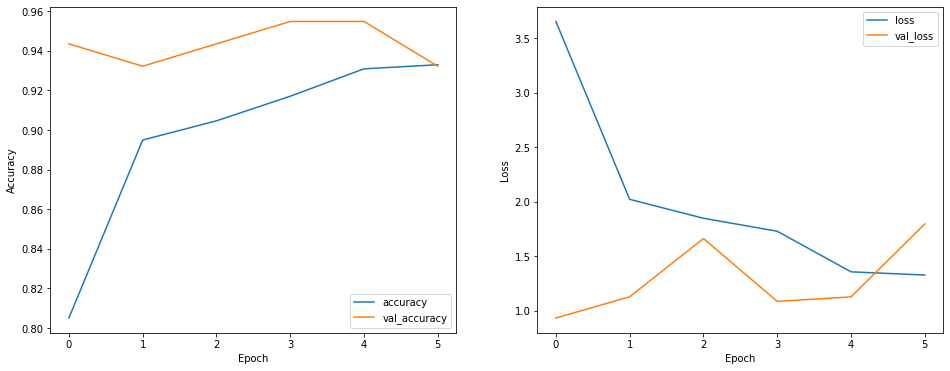

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

## evaluation

Evaluate the performance of the model on the test set

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 107s 21s/step - loss: 0.9029 - accuracy: 0.9316


[0.9029069542884827, 0.9315789341926575]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9315789473684211

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.59      0.77      0.67        13\n           1       0.75      0.52      0.62        23\n           2       0.90      0.58      0.71        31\n           3       0.45      0.90      0.60        10\n           4       0.92      1.00      0.96        22\n           5       0.94      0.94      0.94        18\n           6       0.90      0.90      0.90        21\n           7       0.88      0.64      0.74        22\n           8       0.61      0.85      0.71        13\n           9       0.65      0.76      0.70        17\n\n    accuracy                           0.76       190\n   macro avg       0.76      0.79      0.75       190\nweighted avg       0.80      0.76      0.76       190\n'

# VGG16 10 breeds

## Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=False)

Found 190 images belonging to 10 classes.


## model

VGG16 model with pre-trained weights

In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.Flatten()(x)
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                250890    
Total params: 14,965,578
Trainable params: 250,890
Non-trainable params: 14,714,688
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 24s 517ms/step - loss: 5.5940 - accuracy: 0.1437 - val_loss: 3.6341 - val_accuracy: 0.2712
Epoch 2/100
46/46 [==============================] - 23s 507ms/step - loss: 3.1796 - accuracy: 0.2647 - val_loss: 2.0529 - val_accuracy: 0.3446
Epoch 3/100
46/46 [==============================] - 23s 508ms/step - loss: 2.5734 - accuracy: 0.3574 - val_loss: 2.4811 - val_accuracy: 0.3220
Epoch 4/100
46/46 [==============================] - 24s 513ms/step - loss: 2.4655 - accuracy: 0.3703 - val_loss: 1.5364 - val_accuracy: 0.5311
Epoch 5/100
46/46 [==============================] - 24s 511ms/step - loss: 2.1861 - accuracy: 0.4296 - val_loss: 2.4935 - val_accuracy: 0.4520
Epoch 6/100
46/46 [==============================] - 23s 509ms/step - loss: 2.3617 - accuracy: 0.3996 - val_loss: 2.8679 - val_accuracy: 0.3955
Epoch 7/100
46/46 [==============================] - 23s 507ms/step - loss: 2.2484 - accuracy: 0.4280 - val_loss: 1.5813 - val_accuracy:

## evaluation

Accuracy vs Epochs

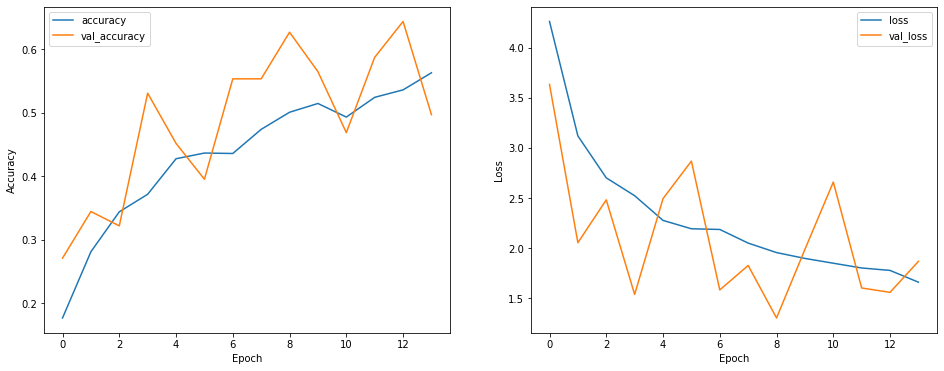

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 2s 310ms/step - loss: 1.6347 - accuracy: 0.5632


[1.6347458362579346, 0.5631579160690308]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))

predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.5631578947368421

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.35      0.43      0.39        14\n           1       0.31      0.56      0.40         9\n           2       0.40      0.67      0.50        12\n           3       0.45      0.47      0.46        19\n           4       0.83      1.00      0.91        20\n           5       0.44      1.00      0.62         8\n           6       0.76      0.80      0.78        20\n           7       0.62      0.40      0.49        25\n           8       0.61      0.46      0.52        24\n           9       0.70      0.36      0.47        39\n\n    accuracy                           0.56       190\n   macro avg       0.55      0.61      0.55       190\nweighted avg       0.60      0.56      0.56       190\n'

# Inception_V3 10 breeds

## Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=False)

Found 190 images belonging to 10 classes.


## model

Inception V3 model with pre-trained weights

In [ ]:
base_model = keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

87916544/87910968 [==============================] - 4s 0us/step


Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.Flatten()(x)
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1310730   
Total params: 23,113,514
Trainable params: 1,310,730
Non-trainable params: 21,802,784
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 42s 798ms/step - loss: 28.6027 - accuracy: 0.4767 - val_loss: 0.9142 - val_accuracy: 0.9266
Epoch 2/100
46/46 [==============================] - 35s 761ms/step - loss: 3.4432 - accuracy: 0.8468 - val_loss: 0.5337 - val_accuracy: 0.9605
Epoch 3/100
46/46 [==============================] - 35s 756ms/step - loss: 3.7485 - accuracy: 0.8696 - val_loss: 2.2657 - val_accuracy: 0.9096
Epoch 4/100
46/46 [==============================] - 35s 758ms/step - loss: 4.0343 - accuracy: 0.8648 - val_loss: 0.8489 - val_accuracy: 0.9548
Epoch 5/100
46/46 [==============================] - 35s 754ms/step - loss: 3.5280 - accuracy: 0.8990 - val_loss: 0.5466 - val_accuracy: 0.9435
Epoch 6/100
46/46 [==============================] - 35s 751ms/step - loss: 3.3667 - accuracy: 0.8971 - val_loss: 2.9972 - val_accuracy: 0.9266
Epoch 7/100
46/46 [==============================] - 35s 753ms/step - loss: 3.2094 - accuracy: 0.9033 - val_loss: 1.5101 - val_accuracy

## evaluation

Accuracy vs Epochs

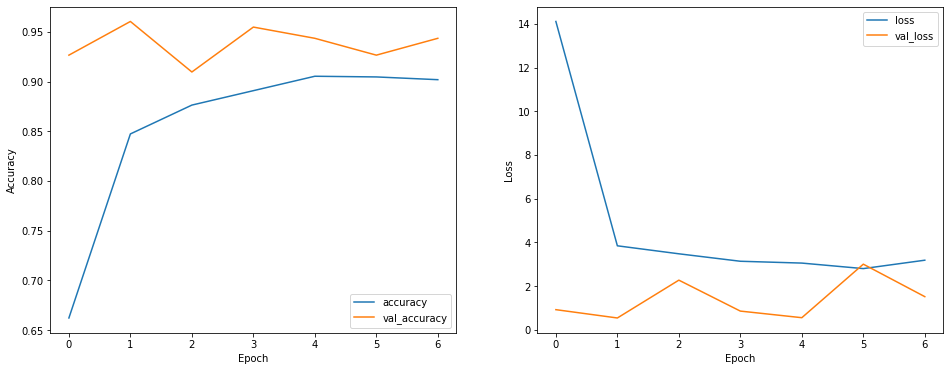

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 2s 309ms/step - loss: 1.2644 - accuracy: 0.9421


[1.2644081115722656, 0.942105233669281]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))

predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9421052631578948

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      0.84      0.89        19\n           1       0.94      0.79      0.86        19\n           2       0.95      1.00      0.97        19\n           3       0.95      1.00      0.97        19\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       0.95      1.00      0.98        20\n           7       1.00      1.00      1.00        16\n           8       0.72      0.93      0.81        14\n           9       0.95      0.86      0.90        22\n\n    accuracy                           0.94       190\n   macro avg       0.94      0.94      0.94       190\nweighted avg       0.95      0.94      0.94       190\n'

Xception and Inception V3 are by far outperforming VGG16. In the next section I will then be focusing on these two models only:

* Hyperparameter tuning (Flatten vs GAP, Optimizers)
* Fine-tuning

# Xception 10 breeds Optim

## **Flatten vs GlobalAveragePooling with RMSProp**

Here, I am updating the previous Xception model by changing only Flatten with Global Average Pooling. 

**Data preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
list(training_set.class_indices.keys())

['American_Staffordshire_terrier',
 'Chihuahua',
 'Ibizan_hound',
 'Saluki',
 'Scottish_deerhound',
 'basset',
 'papillon',
 'redbone',
 'toy_terrier',
 'whippet']

**model**

Xception model with pre-trained weights

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(32, activation='relu')
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 40s 805ms/step - loss: 1.2854 - accuracy: 0.6937 - val_loss: 0.2827 - val_accuracy: 0.9548
Epoch 2/100
46/46 [==============================] - 36s 785ms/step - loss: 0.3347 - accuracy: 0.9263 - val_loss: 0.1560 - val_accuracy: 0.9548
Epoch 3/100
46/46 [==============================] - 36s 786ms/step - loss: 0.2035 - accuracy: 0.9392 - val_loss: 0.1255 - val_accuracy: 0.9605
Epoch 4/100
46/46 [==============================] - 36s 783ms/step - loss: 0.1675 - accuracy: 0.9527 - val_loss: 0.1167 - val_accuracy: 0.9548
Epoch 5/100
46/46 [==============================] - 36s 785ms/step - loss: 0.1613 - accuracy: 0.9522 - val_loss: 0.1079 - val_accuracy: 0.9548
Epoch 6/100
46/46 [==============================] - 36s 787ms/step - loss: 0.1213 - accuracy: 0.9628 - val_loss: 0.1114 - val_accuracy: 0.9548
Epoch 7/100
46/46 [==============================] - 36s 784ms/step - loss: 0.1173 - accuracy: 0.9605 - val_loss: 0.1031 - val_accuracy:

**evaluation**

Accuracy vs Epochs

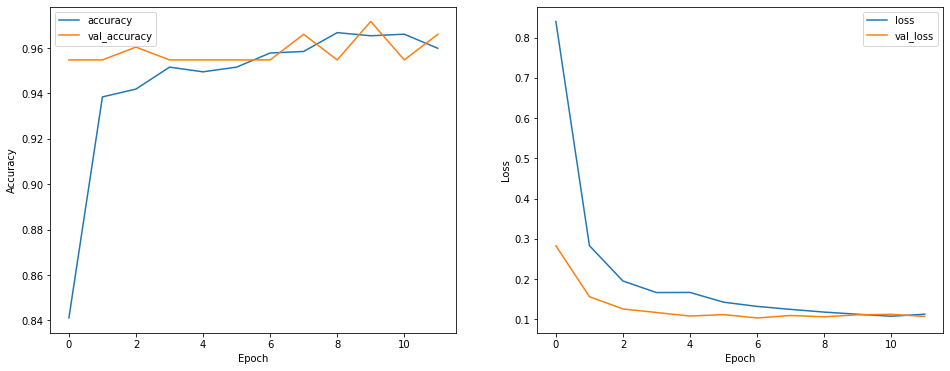

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 217ms/step - loss: 0.0680 - accuracy: 0.9842


[0.06799543648958206, 0.9842105507850647]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9842105263157894

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      1.00      0.97        16\n           1       1.00      0.94      0.97        17\n           2       1.00      0.95      0.98        21\n           3       0.95      1.00      0.97        19\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      1.00      1.00        21\n           7       1.00      1.00      1.00        16\n           8       0.94      1.00      0.97        17\n           9       1.00      0.95      0.98        21\n\n    accuracy                           0.98       190\n   macro avg       0.98      0.98      0.98       190\nweighted avg       0.99      0.98      0.98       190\n'

GlobalAveragePooling2D gives better results than Flatten. GAD2D will be used from now on. So far, I was using RMSProp optimizer by default for all models. I will now be testing 2 other optimizers in the next section.

## Optimizers

I am comparing RMSProp with 2 other optimizers:

*   SGD
*   ADAM



### **SGD**

**Data preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
list(training_set.class_indices.keys())

['American_Staffordshire_terrier',
 'Chihuahua',
 'Ibizan_hound',
 'Saluki',
 'Scottish_deerhound',
 'basset',
 'papillon',
 'redbone',
 'toy_terrier',
 'whippet']

**model**

Xception model with pre-trained weights

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(32, activation='relu')
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 40s 812ms/step - loss: 2.1703 - accuracy: 0.2846 - val_loss: 1.4892 - val_accuracy: 0.8531
Epoch 2/100
46/46 [==============================] - 36s 782ms/step - loss: 1.4392 - accuracy: 0.8170 - val_loss: 0.9864 - val_accuracy: 0.9379
Epoch 3/100
46/46 [==============================] - 36s 781ms/step - loss: 1.0115 - accuracy: 0.9121 - val_loss: 0.7091 - val_accuracy: 0.9548
Epoch 4/100
46/46 [==============================] - 36s 780ms/step - loss: 0.8022 - accuracy: 0.9153 - val_loss: 0.5500 - val_accuracy: 0.9605
Epoch 5/100
46/46 [==============================] - 36s 794ms/step - loss: 0.6136 - accuracy: 0.9452 - val_loss: 0.4507 - val_accuracy: 0.9605
Epoch 6/100
46/46 [==============================] - 36s 775ms/step - loss: 0.5514 - accuracy: 0.9390 - val_loss: 0.3859 - val_accuracy: 0.9605
Epoch 7/100
46/46 [==============================] - 36s 774ms/step - loss: 0.4934 - accuracy: 0.9320 - val_loss: 0.3401 - val_accuracy:

**evaluation**

Accuracy vs Epochs

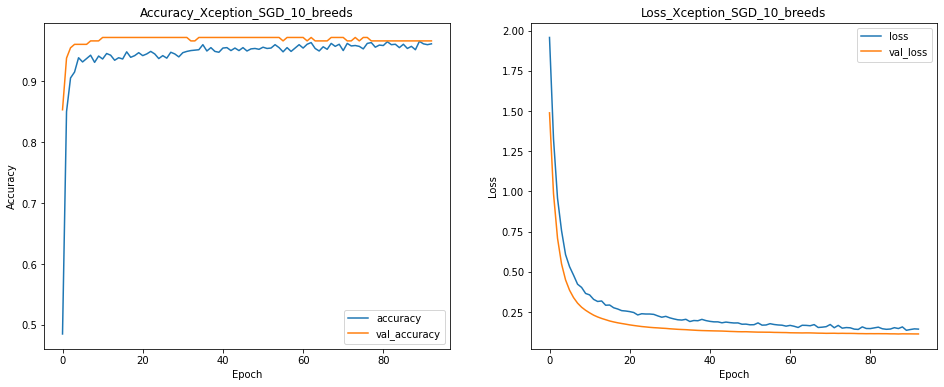

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy_Xception_SGD_10_breeds')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss_Xception_SGD_10_breeds')
ax[1].legend()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 218ms/step - loss: 0.0745 - accuracy: 0.9842


[0.07451289147138596, 0.9842105507850647]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9842105263157894

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      1.00      0.97        16\n           1       1.00      0.94      0.97        17\n           2       1.00      0.95      0.98        21\n           3       1.00      1.00      1.00        20\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      1.00      1.00        21\n           7       1.00      1.00      1.00        16\n           8       0.89      1.00      0.94        16\n           9       1.00      0.95      0.98        21\n\n    accuracy                           0.98       190\n   macro avg       0.98      0.98      0.98       190\nweighted avg       0.99      0.98      0.98       190\n'

### **Adam**

**Data preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
list(training_set.class_indices.keys())

['American_Staffordshire_terrier',
 'Chihuahua',
 'Ibizan_hound',
 'Saluki',
 'Scottish_deerhound',
 'basset',
 'papillon',
 'redbone',
 'toy_terrier',
 'whippet']

**model**

Xception model with pre-trained weights

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(32, activation='relu')
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 40s 804ms/step - loss: 1.6005 - accuracy: 0.5634 - val_loss: 0.3104 - val_accuracy: 0.9605
Epoch 2/100
46/46 [==============================] - 36s 785ms/step - loss: 0.3426 - accuracy: 0.9329 - val_loss: 0.1804 - val_accuracy: 0.9718
Epoch 3/100
46/46 [==============================] - 36s 777ms/step - loss: 0.2505 - accuracy: 0.9421 - val_loss: 0.1493 - val_accuracy: 0.9718
Epoch 4/100
46/46 [==============================] - 36s 777ms/step - loss: 0.2124 - accuracy: 0.9442 - val_loss: 0.1311 - val_accuracy: 0.9718
Epoch 5/100
46/46 [==============================] - 36s 777ms/step - loss: 0.1844 - accuracy: 0.9488 - val_loss: 0.1222 - val_accuracy: 0.9774
Epoch 6/100
46/46 [==============================] - 36s 773ms/step - loss: 0.1586 - accuracy: 0.9567 - val_loss: 0.1156 - val_accuracy: 0.9718
Epoch 7/100
46/46 [==============================] - 36s 772ms/step - loss: 0.1650 - accuracy: 0.9501 - val_loss: 0.1141 - val_accuracy:

**evaluation**

Accuracy vs Epochs

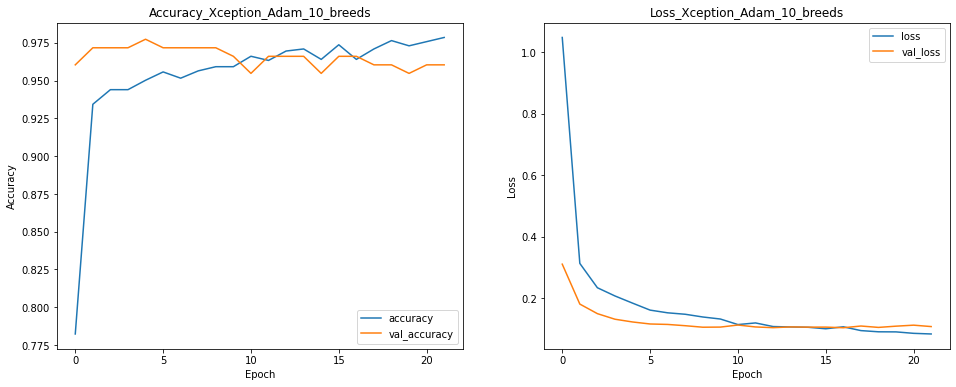

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy_Xception_Adam_10_breeds')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss_Xception_Adam_10_breeds')
ax[1].legend()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 217ms/step - loss: 0.0634 - accuracy: 0.9737


[0.06342556327581406, 0.9736841917037964]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9736842105263158

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      0.89      0.91        18\n           1       1.00      0.94      0.97        17\n           2       1.00      0.95      0.98        21\n           3       1.00      1.00      1.00        20\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      1.00      1.00        21\n           7       1.00      1.00      1.00        16\n           8       0.89      1.00      0.94        16\n           9       0.90      0.95      0.92        19\n\n    accuracy                           0.97       190\n   macro avg       0.97      0.97      0.97       190\nweighted avg       0.98      0.97      0.97       190\n'

Adam and RMSProp gives better results than SGD. I will be using Adam optimizers for the fine-tuning of Xception model.

## Fine tuning

In [ ]:
base_model.trainable=True

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 54s 1s/step - loss: 0.0911 - accuracy: 0.9751 - val_loss: 0.1157 - val_accuracy: 0.9661
Epoch 2/100
46/46 [==============================] - 48s 1s/step - loss: 0.0616 - accuracy: 0.9822 - val_loss: 0.1240 - val_accuracy: 0.9548
Epoch 3/100
46/46 [==============================] - 48s 1s/step - loss: 0.0412 - accuracy: 0.9843 - val_loss: 0.1155 - val_accuracy: 0.9492
Epoch 4/100
46/46 [==============================] - 48s 1s/step - loss: 0.0427 - accuracy: 0.9850 - val_loss: 0.1430 - val_accuracy: 0.9548
Epoch 5/100
46/46 [==============================] - 48s 1s/step - loss: 0.0626 - accuracy: 0.9822 - val_loss: 0.1189 - val_accuracy: 0.9661
Epoch 6/100
46/46 [==============================] - 48s 1s/step - loss: 0.0372 - accuracy: 0.9890 - val_loss: 0.1242 - val_accuracy: 0.9492
Epoch 7/100
46/46 [==============================] - 48s 1s/step - loss: 0.0295 - accuracy: 0.9907 - val_loss: 0.1371 - val_accuracy: 0.9661
Epoch 8/100
4

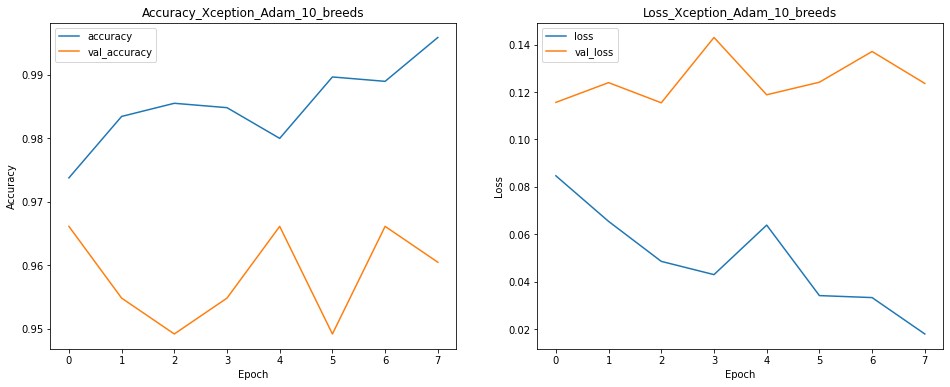

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy_Xception_Adam_10_breeds')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss_Xception_Adam_10_breeds')
ax[1].legend()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 220ms/step - loss: 0.0527 - accuracy: 0.9789


[0.05272899568080902, 0.9789473414421082]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9789473684210527

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      1.00      0.97        16\n           1       1.00      0.94      0.97        17\n           2       1.00      0.95      0.98        21\n           3       0.95      1.00      0.97        19\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      1.00      1.00        21\n           7       1.00      1.00      1.00        16\n           8       0.89      1.00      0.94        16\n           9       1.00      0.91      0.95        22\n\n    accuracy                           0.98       190\n   macro avg       0.98      0.98      0.98       190\nweighted avg       0.98      0.98      0.98       190\n'

# Inception_V3 10 breeds Optim

## Optimizers

I will be comparing 3 optimizers:

*   SGD
*   RMSPROP
*   ADAM



### **RMSPROP**

**Data preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
list(training_set.class_indices.keys())

['American_Staffordshire_terrier',
 'Chihuahua',
 'Ibizan_hound',
 'Saluki',
 'Scottish_deerhound',
 'basset',
 'papillon',
 'redbone',
 'toy_terrier',
 'whippet']

**model**

Xception model with pre-trained weights

In [ ]:
base_model = keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(32, activation='relu')
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 41s 800ms/step - loss: 1.4155 - accuracy: 0.6252 - val_loss: 0.2414 - val_accuracy: 0.9661
Epoch 2/100
46/46 [==============================] - 35s 766ms/step - loss: 0.3480 - accuracy: 0.9238 - val_loss: 0.1148 - val_accuracy: 0.9831
Epoch 3/100
46/46 [==============================] - 35s 760ms/step - loss: 0.2436 - accuracy: 0.9250 - val_loss: 0.1066 - val_accuracy: 0.9661
Epoch 4/100
46/46 [==============================] - 35s 759ms/step - loss: 0.1960 - accuracy: 0.9498 - val_loss: 0.0815 - val_accuracy: 0.9831
Epoch 5/100
46/46 [==============================] - 35s 757ms/step - loss: 0.1874 - accuracy: 0.9496 - val_loss: 0.1040 - val_accuracy: 0.9605
Epoch 6/100
46/46 [==============================] - 35s 761ms/step - loss: 0.1740 - accuracy: 0.9437 - val_loss: 0.0889 - val_accuracy: 0.9661
Epoch 7/100
46/46 [==============================] - 35s 755ms/step - loss: 0.1695 - accuracy: 0.9473 - val_loss: 0.0634 - val_accuracy:

**evaluation**

Accuracy vs Epochs

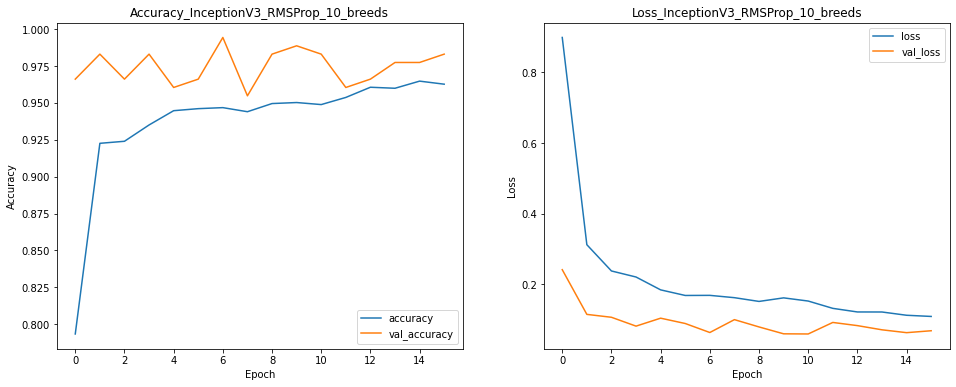

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy_InceptionV3_RMSProp_10_breeds')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss_InceptionV3_RMSProp_10_breeds')
ax[1].legend()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 206ms/step - loss: 0.0894 - accuracy: 0.9421


[0.08944632112979889, 0.942105233669281]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9421052631578948

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      0.89      0.91        18\n           1       0.88      0.88      0.88        16\n           2       0.90      0.95      0.92        19\n           3       0.95      1.00      0.97        19\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      0.95      0.98        22\n           7       1.00      1.00      1.00        16\n           8       0.72      0.87      0.79        15\n           9       1.00      0.87      0.93        23\n\n    accuracy                           0.94       190\n   macro avg       0.94      0.94      0.94       190\nweighted avg       0.95      0.94      0.94       190\n'

**Data preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


**model**

Xception model with pre-trained weights

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(32, activation='relu')
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 40s 803ms/step - loss: 1.4505 - accuracy: 0.6642 - val_loss: 0.2896 - val_accuracy: 0.9605
Epoch 2/100
46/46 [==============================] - 36s 780ms/step - loss: 0.3454 - accuracy: 0.9288 - val_loss: 0.1735 - val_accuracy: 0.9718
Epoch 3/100
46/46 [==============================] - 36s 781ms/step - loss: 0.2425 - accuracy: 0.9378 - val_loss: 0.1442 - val_accuracy: 0.9661
Epoch 4/100
46/46 [==============================] - 36s 784ms/step - loss: 0.2152 - accuracy: 0.9389 - val_loss: 0.1337 - val_accuracy: 0.9605
Epoch 5/100
46/46 [==============================] - 36s 781ms/step - loss: 0.1864 - accuracy: 0.9466 - val_loss: 0.1252 - val_accuracy: 0.9605
Epoch 6/100
46/46 [==============================] - 36s 777ms/step - loss: 0.1552 - accuracy: 0.9599 - val_loss: 0.1280 - val_accuracy: 0.9661
Epoch 7/100
46/46 [==============================] - 36s 776ms/step - loss: 0.1501 - accuracy: 0.9562 - val_loss: 0.1164 - val_accuracy:

**evaluation**

Accuracy vs Epochs

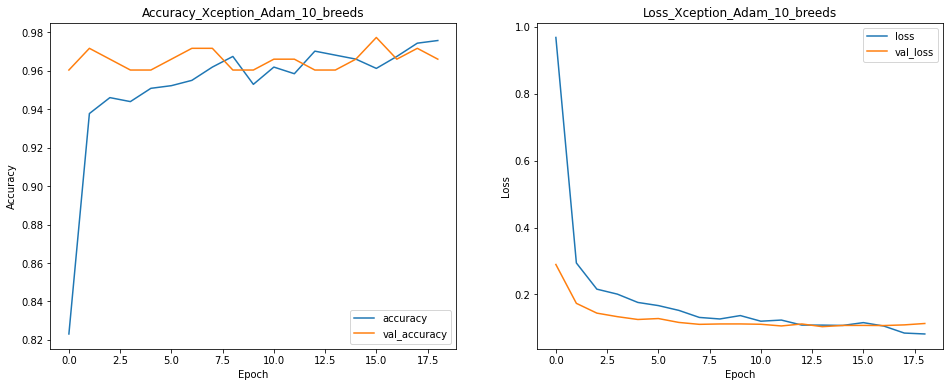

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy_Xception_Adam_10_breeds')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss_Xception_Adam_10_breeds')
ax[1].legend()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 213ms/step - loss: 0.0547 - accuracy: 0.9895


[0.05474743992090225, 0.9894737005233765]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9894736842105263

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      1.00      0.97        16\n           1       1.00      0.94      0.97        17\n           2       1.00      0.95      0.98        21\n           3       1.00      1.00      1.00        20\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      1.00      1.00        21\n           7       1.00      1.00      1.00        16\n           8       0.94      1.00      0.97        17\n           9       1.00      1.00      1.00        20\n\n    accuracy                           0.99       190\n   macro avg       0.99      0.99      0.99       190\nweighted avg       0.99      0.99      0.99       190\n'

### **Adam**

**Data preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


**model**

Inception model with pre-trained weights

In [ ]:
base_model = keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

Freeze the base model

In [ ]:
base_model.trainable = False

Create new model on top

In [ ]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(32, activation='relu')
# A Dense classifier (10 class)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


Train the model on new data

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True
                                        )
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 41s 801ms/step - loss: 1.5086 - accuracy: 0.5605 - val_loss: 0.2321 - val_accuracy: 0.9605
Epoch 2/100
46/46 [==============================] - 35s 766ms/step - loss: 0.3378 - accuracy: 0.9121 - val_loss: 0.1368 - val_accuracy: 0.9661
Epoch 3/100
46/46 [==============================] - 35s 768ms/step - loss: 0.2595 - accuracy: 0.9245 - val_loss: 0.1024 - val_accuracy: 0.9774
Epoch 4/100
46/46 [==============================] - 35s 767ms/step - loss: 0.2071 - accuracy: 0.9420 - val_loss: 0.0940 - val_accuracy: 0.9718
Epoch 5/100
46/46 [==============================] - 35s 767ms/step - loss: 0.1533 - accuracy: 0.9563 - val_loss: 0.0849 - val_accuracy: 0.9661
Epoch 6/100
46/46 [==============================] - 35s 768ms/step - loss: 0.1747 - accuracy: 0.9432 - val_loss: 0.0833 - val_accuracy: 0.9718
Epoch 7/100
46/46 [==============================] - 35s 764ms/step - loss: 0.1726 - accuracy: 0.9449 - val_loss: 0.0962 - val_accuracy:

**evaluation**

Accuracy vs Epochs

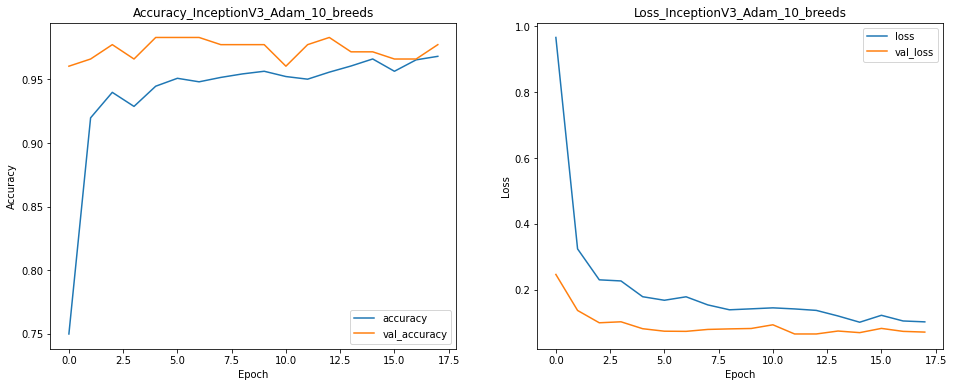

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy_InceptionV3_Adam_10_breeds')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss_InceptionV3_Adam_10_breeds')
ax[1].legend()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 206ms/step - loss: 0.1032 - accuracy: 0.9579


[0.10320128500461578, 0.9578947424888611]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.968421052631579

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      1.00      0.97        16\n           1       0.88      0.88      0.88        16\n           2       1.00      0.95      0.98        21\n           3       0.95      1.00      0.97        19\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      1.00      1.00        21\n           7       1.00      1.00      1.00        16\n           8       0.89      0.89      0.89        18\n           9       1.00      0.95      0.98        21\n\n    accuracy                           0.97       190\n   macro avg       0.97      0.97      0.97       190\nweighted avg       0.97      0.97      0.97       190\n'

## Fine tuning

In [ ]:
base_model.trainable=True

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fit = model.fit(training_set, epochs=100,
          callbacks=[earlystopping], 
          validation_data=validation_set)

Epoch 1/100
46/46 [==============================] - 48s 870ms/step - loss: 0.1257 - accuracy: 0.9515 - val_loss: 0.0821 - val_accuracy: 0.9718
Epoch 2/100
46/46 [==============================] - 39s 848ms/step - loss: 0.1046 - accuracy: 0.9669 - val_loss: 0.0987 - val_accuracy: 0.9661
Epoch 3/100
46/46 [==============================] - 39s 843ms/step - loss: 0.0739 - accuracy: 0.9796 - val_loss: 0.0850 - val_accuracy: 0.9661
Epoch 4/100
46/46 [==============================] - 39s 843ms/step - loss: 0.0683 - accuracy: 0.9795 - val_loss: 0.1033 - val_accuracy: 0.9548
Epoch 5/100
46/46 [==============================] - 39s 840ms/step - loss: 0.0485 - accuracy: 0.9860 - val_loss: 0.0759 - val_accuracy: 0.9718
Epoch 6/100
46/46 [==============================] - 39s 839ms/step - loss: 0.0410 - accuracy: 0.9875 - val_loss: 0.1202 - val_accuracy: 0.9661
Epoch 7/100
46/46 [==============================] - 39s 856ms/step - loss: 0.0351 - accuracy: 0.9866 - val_loss: 0.0639 - val_accuracy:

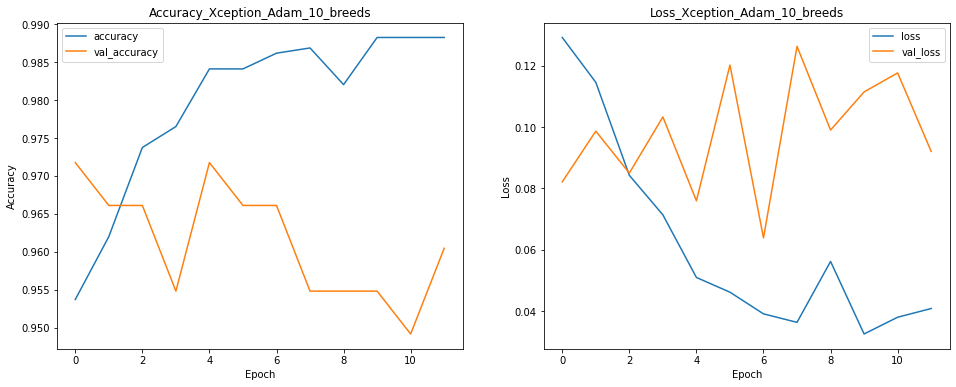

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy_Xception_Adam_10_breeds')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss_Xception_Adam_10_breeds')
ax[1].legend()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
prediction = model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 212ms/step - loss: 0.0614 - accuracy: 0.9737


[0.061373189091682434, 0.9736841917037964]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(predicted_classes, test_set.classes)

0.9736842105263158

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      0.94      0.94        17\n           1       0.88      0.93      0.90        15\n           2       1.00      0.95      0.98        21\n           3       0.95      1.00      0.97        19\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      1.00      1.00        21\n           7       1.00      1.00      1.00        16\n           8       0.94      0.94      0.94        18\n           9       1.00      0.95      0.98        21\n\n    accuracy                           0.97       190\n   macro avg       0.97      0.97      0.97       190\nweighted avg       0.97      0.97      0.97       190\n'

## save model

In [ ]:
# serialize model to JSON
inception_10_breeds_json = model.to_json()
with open("inception_10_breeds.json", "w") as json_file:
    json_file.write(inception_10_breeds_json)
# serialize weights to HDF5
model.save_weights("inception_10_breeds.h5")
print("Saved model to disk")

Saved model to disk


## Classification

In [ ]:
# load json and create model
json_file = open('inception_10_breeds.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("inception_10_breeds.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
prediction = loaded_model.evaluate(test_set)
prediction

6/6 [==============================] - 1s 206ms/step - loss: 0.0614 - accuracy: 0.9737


[0.061373189091682434, 0.9736841917037964]

In [ ]:
predicted_probabilities = model.predict(test_set)

In [ ]:
l=[]
for proba in predicted_probabilities:
  l.append(np.argmax(proba))

In [ ]:
predicted_classes = np.array(l)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy_score(predicted_classes, test_set.classes)

0.9736842105263158

In [ ]:
classification_report(predicted_classes, test_set.classes)

'              precision    recall  f1-score   support\n\n           0       0.94      0.94      0.94        17\n           1       0.88      0.93      0.90        15\n           2       1.00      0.95      0.98        21\n           3       0.95      1.00      0.97        19\n           4       1.00      1.00      1.00        24\n           5       1.00      1.00      1.00        18\n           6       1.00      1.00      1.00        21\n           7       1.00      1.00      1.00        16\n           8       0.94      0.94      0.94        18\n           9       1.00      0.95      0.98        21\n\n    accuracy                           0.97       190\n   macro avg       0.97      0.97      0.97       190\nweighted avg       0.97      0.97      0.97       190\n'

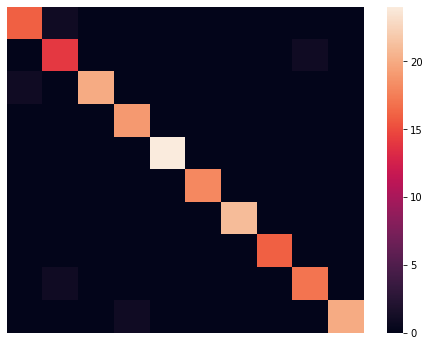

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))
plt.axis('off')
confusion = confusion_matrix(predicted_classes, test_set.classes)
sns.heatmap(confusion)

In [ ]:
confusion

array([[16,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 1,  0, 20,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 24,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 18,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 21,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 17,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 20]])

In [ ]:
1-5/190

0.9736842105263158

There are only 5 images not correctly predicted within the test set:
* 2 among class 1 (Chihuahua)
* 1 among classes 0,3,8 (American_terrier, Saluki, toy_terrier)
* 6 classes are perfectly predicted
* 4 classes have precision & recall = 1 (scottish, basset, papillon, redbone)


In [ ]:
test_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}